In [1]:
# npb
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('../maroon_ipynb.mplstyle')

# Example 3.2
Solve the following ODE with $f(t)=200u(t)$ and $\dot{x}(0)=v_0$. All other initial conditions are zero.

$$2\;\ddddot{x}+14\;\dddot{x}+46.5\ddot{x}+127\dot{x}+148x=f(t)$$

## Important Note with Sympy
One of the major caveats of `sympy` is that you should never include a decimal value in a symbolic expression. This may lead to errors depending on what you are trying to accomplish. You can work around this by representing the decimal value as a fraction or using `Rational` from `sympy`.

For example, let's say you want to evaluate $\frac{0.1}{0.3}x$.

In [2]:
# do not do this
x = sp.Symbol('x')
expr = 0.1/0.3*x
expr

0.333333333333333*x

This might seem ok, but if you expand that floating point value, you will see floating point error. You can adjust the amount of decimals that `sympy` will output with the `n()` method.

In [3]:
expr.n(20)

0.33333333333333337034*x

Here is the fix using `Rational`.

In [4]:
numerator = sp.Rational(1, 10)
numerator  # this will correctly represent 0.1 as a fraction

1/10

In [5]:
denominator = sp.Rational(3, 10)
expr_correct = numerator/denominator*x
expr_correct

x/3

In [6]:
expr_correct.n(20)

0.33333333333333333333*x

## Solving the Easy Way
The best way to solve this with `sympy` would be to use the `dsolve` function.

In [7]:
t, v0 = sp.symbols('t v0', real=True)  # somtimes it's necessary to specify that the symbol is real
x = sp.Function('x')(t)
eq = sp.Eq(2*x.diff(t, 4) + 14*x.diff(t, 3) + sp.Rational(93, 2)*x.diff(t, 2) + 127*x.diff(t) + 148*x, 200*sp.Heaviside(t))
eq

Eq(148*x(t) + 127*Derivative(x(t), t) + 93*Derivative(x(t), (t, 2))/2 + 14*Derivative(x(t), (t, 3)) + 2*Derivative(x(t), (t, 4)), 200*Heaviside(t))

In [8]:
sol = sp.dsolve(eq, ics={
    x.subs(t, 0): 0,
    x.diff(t, 1).subs(t, 0): v0,
    x.diff(t, 2).subs(t, 0): 0,
    x.diff(t, 3).subs(t, 0): 0
})
sol

Eq(x(t), (-9*v0/34 + 10*Heaviside(t)/17)*exp(-4*t) + (53*v0/90 - 20*Heaviside(t)/9)*exp(-2*t) + ((-248*v0/765 + 1600*Heaviside(t)/5661)*cos(3*t) + (244*v0/765 - 3680*Heaviside(t)/5661)*sin(3*t))*exp(-t/2) + 50*Heaviside(t)/37)

It is very nice that it was able to solve this and retain the $v_0$ symbol in the solution. We can bring this to the numerical world with `lambdify`.

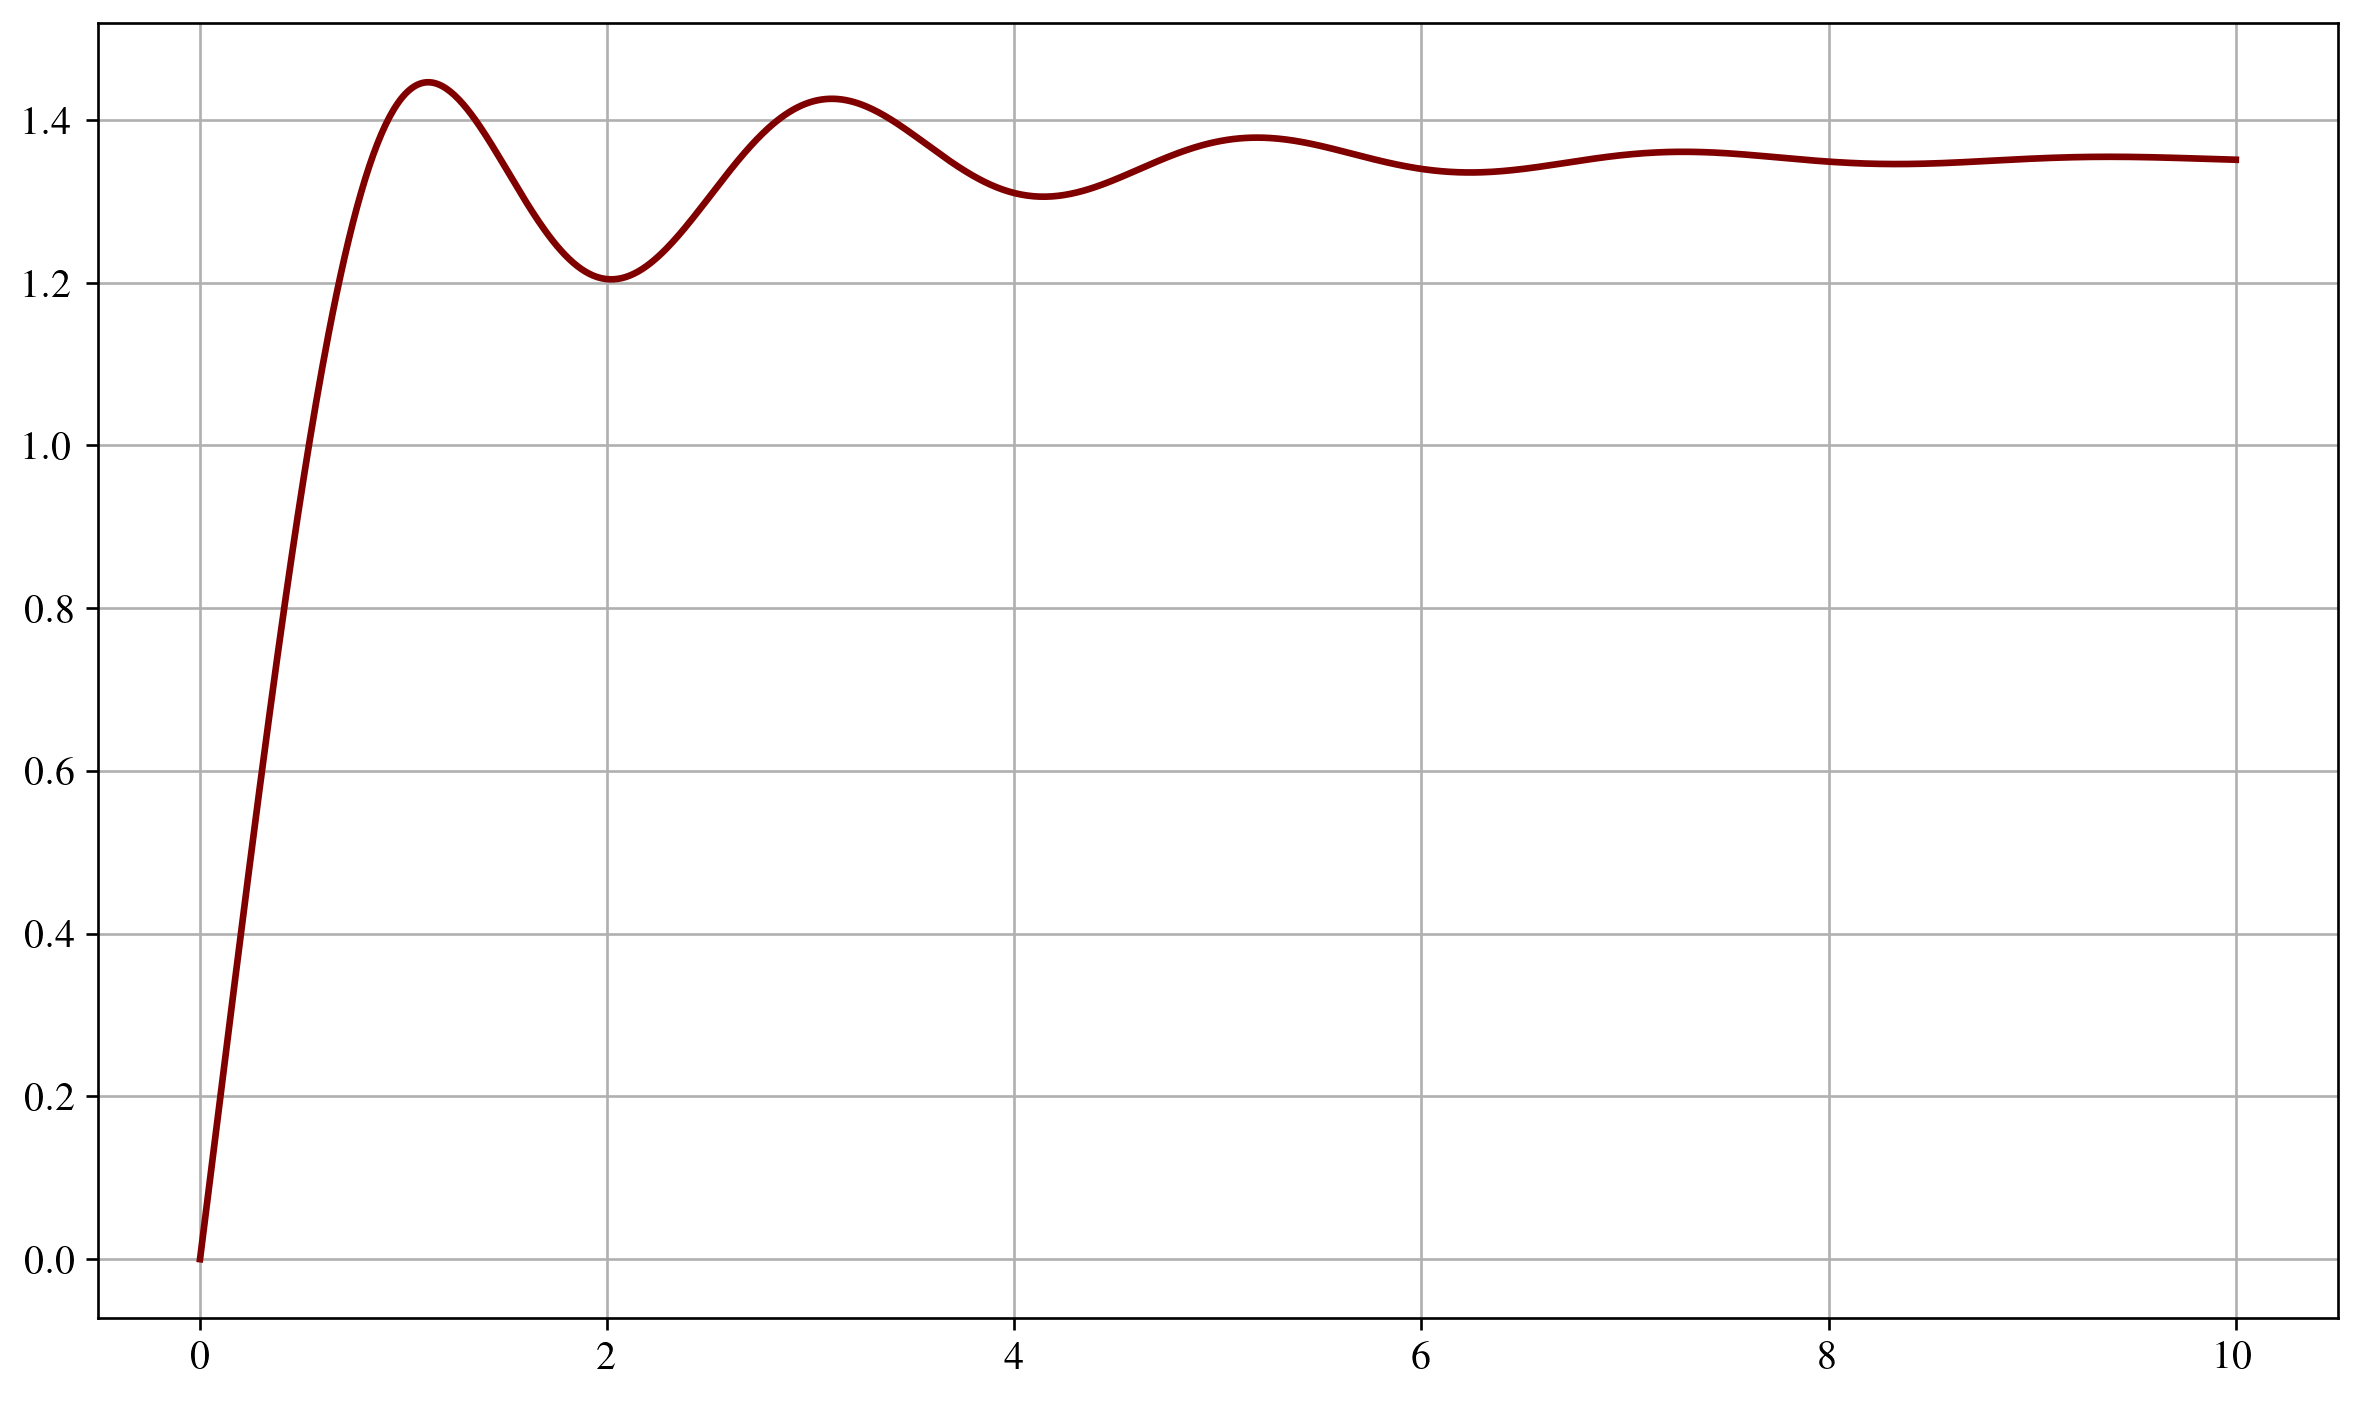

In [9]:
# Substitute v0 with 2
sol_sub = sol.rhs.subs(v0, 2)

t_array = np.linspace(0, 10, 1000)
x_lamb = sp.lambdify(t, sol_sub, modules='numpy')

fig, ax = plt.subplots()
ax.plot(t_array, x_lamb(t_array))
plt.show()

## Solving with Laplace Transforms

In [10]:
# Putting the original equation into the Laplace domain
s = sp.Symbol('s', real=True)
eq_s = sp.Eq(sp.laplace_transform(eq.lhs, t, s)[0], sp.laplace_transform(eq.rhs, t, s)[0])
eq_s

Eq(2*s**4*LaplaceTransform(x(t), t, s) + 14*s**3*LaplaceTransform(x(t), t, s) - 2*s**3*x(0) + 93*s**2*LaplaceTransform(x(t), t, s)/2 - 14*s**2*x(0) - 2*s**2*Subs(Derivative(x(t), t), t, 0) + 127*s*LaplaceTransform(x(t), t, s) - 93*s*x(0)/2 - 14*s*Subs(Derivative(x(t), t), t, 0) - 2*s*Subs(Derivative(x(t), (t, 2)), t, 0) + 148*LaplaceTransform(x(t), t, s) - 127*x(0) - 93*Subs(Derivative(x(t), t), t, 0)/2 - 14*Subs(Derivative(x(t), (t, 2)), t, 0) - 2*Subs(Derivative(x(t), (t, 3)), t, 0), 200/s)

In the past, `sympy`'s laplace transforms would not apply the rule with the derivatives, but this changed in 2023 as you can clearly see the $s$ terms.

In [11]:
# Applying the initial conditions
eq_s = eq_s.subs([
    (x.subs(t, 0), 0),
    (x.diff(t, 1).subs(t, 0), v0),
    (x.diff(t, 2).subs(t, 0), 0),
    (x.diff(t, 3).subs(t, 0), 0)
])
eq_s

Eq(2*s**4*LaplaceTransform(x(t), t, s) + 14*s**3*LaplaceTransform(x(t), t, s) - 2*s**2*v0 + 93*s**2*LaplaceTransform(x(t), t, s)/2 - 14*s*v0 + 127*s*LaplaceTransform(x(t), t, s) - 93*v0/2 + 148*LaplaceTransform(x(t), t, s), 200/s)

In [12]:
# Solving for X(s)
X_s = sp.solve(eq_s, sp.laplace_transform(x, t, s)[0])[0]
X_s

(4*s**3*v0 + 28*s**2*v0 + 93*s*v0 + 400)/(s*(4*s**4 + 28*s**3 + 93*s**2 + 254*s + 296))

Though I don't think there is a need, you can still use the partial fraction form if you wanted to do this by hand. Sometimes, `sympy` will solve the inverse laplace transform better in this form, but I haven't had any issues with inverse laplace transforms for a while.

In [13]:
X_s_partial = sp.apart(X_s, s)  # must include the 's' because we have v0 in the expression
X_s_partial

-32*(1147*s*v0 - 1000*s - 2812*v0 + 6400)/(28305*(4*s**2 + 4*s + 37)) - (9*v0 - 20)/(34*(s + 4)) + (53*v0 - 200)/(90*(s + 2)) + 50/(37*s)

### Pro tip
Let's say we wanted to extract the characteristic polynomial from the above $X(s)$ expression and find its roots. First off, it would have been better to leave $f(t)$ in its symbolic form and find the transfer function, but we can get around this with what we have already done by dividing out $f(t)$.

In [14]:
# Get transfer function
T_s = X_s/(200/s)
T_s

(4*s**3*v0 + 28*s**2*v0 + 93*s*v0 + 400)/(200*(4*s**4 + 28*s**3 + 93*s**2 + 254*s + 296))

It may not be in the form that we would perceive as the characteristic polynomial, but it's roots will still be the same.

In [15]:
# Use sp.fraction to get the numerator and denominator
num, den = sp.fraction(T_s)
den

800*s**4 + 5600*s**3 + 18600*s**2 + 50800*s + 59200

In [16]:
cp = den/400  # returns original characteristic polynomial
cp

2*s**4 + 14*s**3 + 93*s**2/2 + 127*s + 148

In [17]:
# you can use sp.solve to get the roots
# or you can create a polynomial object and use the nroots method
cp_poly = sp.Poly(cp, s)
roots = cp_poly.nroots()
display(*roots)

-4.00000000000000

-2.00000000000000

-0.5 - 3.0*I

-0.5 + 3.0*I

## Inverse Laplace Transform
Going back to solving, all we have to do now is take the inverse laplace transform.

In [18]:
sol = sp.inverse_laplace_transform(X_s, s, t)
sol

(10/17 - 9*v0/34)*exp(-4*t)*Heaviside(t) + (53*v0/90 - 20/9)*exp(-2*t)*Heaviside(t) + ((1600/5661 - 248*v0/765)*exp(-t/2)*cos(3*t) + (244*v0/765 - 3680/5661)*exp(-t/2)*sin(3*t))*Heaviside(t) + 50*Heaviside(t)/37

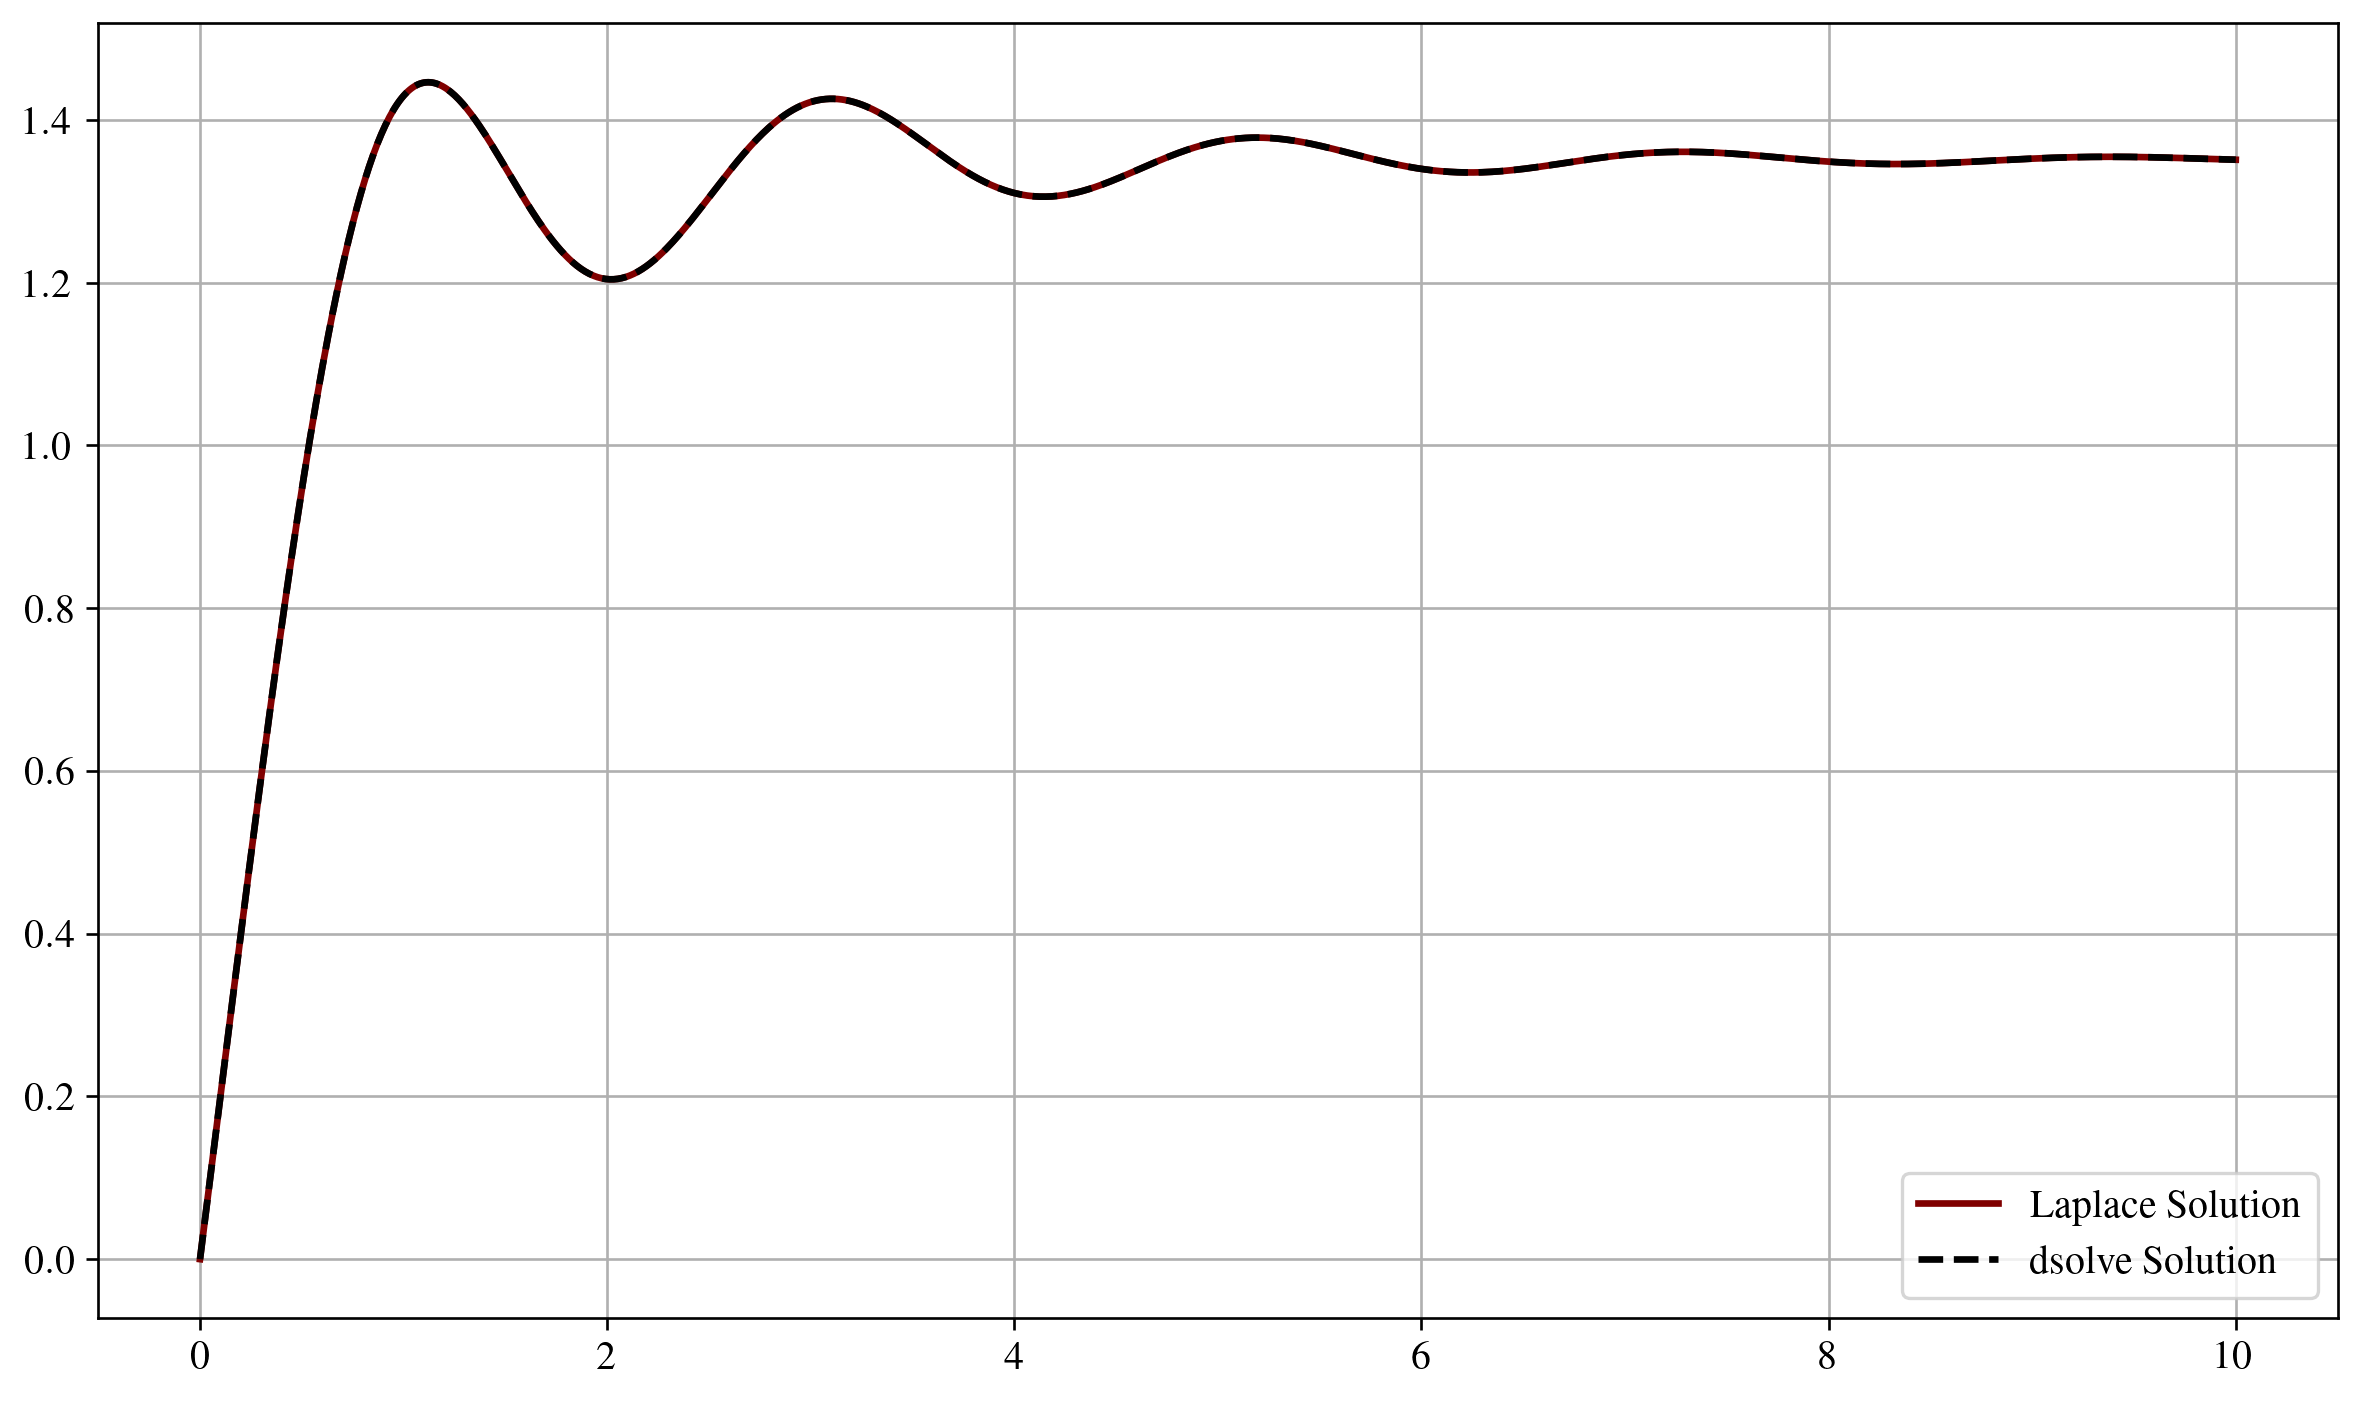

In [19]:
# Substitute v0 with 2
# Let's see if it's the same as the dsolve solution
x_t = sol.subs(v0, 2)
x_t_lamb = sp.lambdify(t, x_t, modules='numpy')

fig, ax = plt.subplots()
ax.plot(t_array, x_t_lamb(t_array), label='Laplace Solution')
ax.plot(t_array, x_lamb(t_array), ls='--', label='dsolve Solution')
ax.legend()
plt.show()

A couple of things to note about this result:

- The dominant root is the root whose real part has the smallest magnitude. This results in the largest time constant. The time constant then for this ODE is $-\frac{1}{-0.5}=2$. Notice that the solution arrives close to steady state at $4\cdot2=8$ seconds.
- Since our characteristic polynomial has imaginary roots, we see oscillation. We can recognize that the oscillations occur at $3\,rad/s$. The period in seconds is $2\pi/3\approx2.1\,s$, and we can see that the peak to peak distance in the output matches this value.